In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Following functions only work in 2-dimensions, i.e. X with 2 features
# And upto 5 clusters/classes

def get_minmax(_X, _m):  # _m = margin for visuals
    return _X[:,0].min()-_m, _X[:,0].max()+_m, _X[:,1].min()-_m, _X[:,1].max()+_m

def plotX(_X, _y, ax=None):  # Max 5 clusters/classes
    Colors = ['darkorchid', 'darkgreen', 'darkgrey', 'darksalmon', 'darkseagreen']
    Markers = ['o', '+', 'x', '1', '.']
    for c in range(max(_y)+1):
        plt.scatter(_X[_y==c,0], _X[_y==c,1], marker=Markers[c], color=Colors[c])
    if ax is not None:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    #
    x1_min, x1_max, x2_min, x2_max = get_minmax(_X, 1)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.xlabel(r'$x_1$', horizontalalignment='right', x=1.0)
    plt.ylabel(r'$x_2$', horizontalalignment='right', y=1.0)

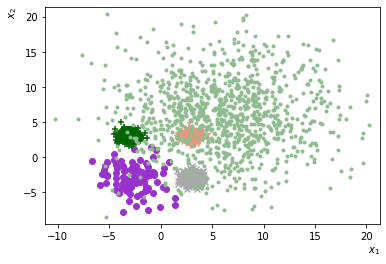

In [2]:
from sklearn.datasets import make_blobs

# 5 classes with 2 features
X1, y1 = make_blobs(n_samples=(100, 500, 500, 500, 1000), n_features=2, random_state=1,
                    cluster_std=[2, .5, .5, .5, 5],
                    centers=[(-3, -3), (-3, 3), (3, -3), (3, 3), (6, 6)])
#
plotX(X1, y1)

In [3]:
# Build a Naive Bayes classifier from scratch for numerical features
#
from scipy.stats import norm
import numpy as np

class CustomNaiveBayes:  # Numerical features
    def __init__(self):
        self.N, self.M, self.Cn = None, None, None  
        self.Prior, self.Predictors, self.Likelihood = None, None, None
    #
    def fit(self, _Xtrain, _ytrain):
        self.N, self.M = _Xtrain.shape
        self.Cn = len(np.unique(_ytrain))  # Class numbers must be integer and starting from 0
        assert min(_ytrain)==0 and max(_ytrain)==self.Cn-1  # Error check
        #
        # Prior probabilities - probability mass function
        self.Prior = np.bincount(_ytrain) / self.N
        #
        # Predictor probabilities
        # The predictors - list of (mu,std)
        self.Predictors = np.array([norm.fit(_Xtrain[:,_]) for _ in range(self.M)])
        #
        # Likelihood probabilities
        # Dictionary of {list of (mu,std) per feature} per class
        self.Likelihood = np.empty((self.Cn,self.M,2))
        for c in range(self.Cn):
            self.Likelihood[c] = np.array([norm.fit(_Xtrain[np.where(_ytrain==c),_]) for _ in range(self.M)])
        # Classifier model is composed of the data structures
        # Prior, Predictors, and Likelihood
        return self
    #
    def predict(self, _Xtest):
        y_pred = np.empty(len(_Xtest), dtype=np.int32)
        for i, x in enumerate(_Xtest):
            # Bayes rule based on training
            p_Likelihood = norm.pdf(x, self.Likelihood[:,:,0], self.Likelihood[:,:,1])
            p_Predictors = norm.pdf(x, self.Predictors[:,0], self.Predictors[:,1])
            # Take product of the feature probabilities - independence assumption
            p = self.Prior*np.prod(p_Likelihood/p_Predictors, axis=1)  # Eq.1
            y_pred[i] = np.argmax(p)
        #
        return y_pred

In [4]:
%%time
from sklearn.metrics import accuracy_score

# Sanity check
clf2 = CustomNaiveBayes().fit(X1, y1)
y_pred = clf2.predict(X1)

print(f'Reclassification accuracy: {accuracy_score(y1, y_pred):.3f}')

Reclassification accuracy: 0.971
Wall time: 831 ms


In [5]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

def eval_classifier(_clf, _X, _y, _niter, text=''):
    accs = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)
    for train_index, test_index in kf.split(_X, _y):
        model = _clf.fit(_X[train_index], _y[train_index])
        y_pred = _clf.predict(_X[test_index])
        accs += [accuracy_score(_y[test_index], y_pred)]
    #
    print(f'{text} Stratified 10-fold CV acc={np.mean(accs):.3f} with {_niter} iterations')

eval_classifier(CustomNaiveBayes(), X1, y1, 10, 'CustomNaiveBayes')
eval_classifier(GaussianNB(), X1, y1, 10, 'sklearn GaussianNB')
eval_classifier(SVC(class_weight='balanced', kernel='linear', C=2), X1, y1, 10, 'SVM (linear)')
eval_classifier(SVC(class_weight='balanced', kernel='rbf', gamma=2, C=2), X1, y1, 10, 'SVM (rbf)')

CustomNaiveBayes Stratified 10-fold CV acc=0.971 with 10 iterations
sklearn GaussianNB Stratified 10-fold CV acc=0.971 with 10 iterations
SVM (linear) Stratified 10-fold CV acc=0.868 with 10 iterations
SVM (rbf) Stratified 10-fold CV acc=0.963 with 10 iterations
Wall time: 6.05 s


In [6]:
def plot_decisionboundary(_X, _clf, _h, color_db='r'):  # _h = step size in the mesh
    x1_min, x1_max, x2_min, x2_max = get_minmax(_X, 1)
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, _h), np.arange(x2_min, x2_max, _h))
    Y = _clf.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    # debug
    # print(np.unique(Y,return_counts=True))
    #
    plt.contour(xx1, xx2, Y, colors=color_db, linestyles='dotted')

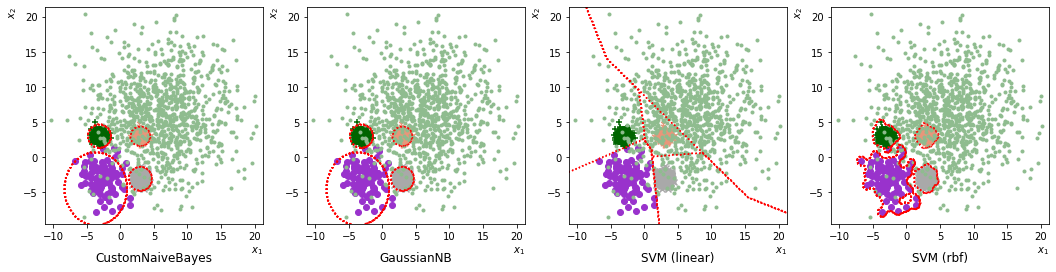

In [7]:
h = 0.1  # mesh granularity of the plot

plt.figure(figsize=(18, 4))
#
ax=plt.subplot(1, 4, 1)
plotX(X1, y1)
clf = CustomNaiveBayes().fit(X1, y1)
plot_decisionboundary(X1, clf, h)
plt.title('CustomNaiveBayes', y=-0.2)
#
ax=plt.subplot(1, 4, 2)
plotX(X1, y1)
clf = GaussianNB().fit(X1, y1)
plot_decisionboundary(X1, clf, h)
plt.title('GaussianNB', y=-0.2)
#
ax=plt.subplot(1, 4, 3)
plotX(X1, y1)
clf = SVC(class_weight='balanced', kernel='linear', C=2).fit(X1, y1)
plot_decisionboundary(X1, clf, h)
plt.title('SVM (linear)', y=-0.2)
#
ax=plt.subplot(1, 4, 4)
plotX(X1, y1)
clf = SVC(class_weight='balanced', kernel='rbf', gamma=2, C=2).fit(X1, y1)
plot_decisionboundary(X1, clf, h)
plt.title('SVM (rbf)', y=-0.2)
#
plt.show()

In [8]:
import nltk
from nltk.corpus import reuters
import numpy as np
import pandas as pd

Documents = [reuters.raw(fid) for fid in reuters.fileids()]

# Categories are list of lists since each news may have more than 1 category
Categories = [reuters.categories(fid) for fid in reuters.fileids()]
CategoriesList = [_ for sublist in Categories for _ in sublist]
CategoriesSet = np.unique(CategoriesList)

print(f'N documents={len(Documents):d}, K unique categories={len(CategoriesSet):d}')

N documents=10788, K unique categories=90


In [9]:
from collections import Counter

# Check the categories and their counts
counts = Counter(CategoriesList)
counts = sorted(counts.items(), key=lambda pair: pair[1], reverse=True)

print(counts[:10])

[('earn', 3964), ('acq', 2369), ('money-fx', 717), ('grain', 582), ('crude', 578), ('trade', 485), ('interest', 478), ('ship', 286), ('wheat', 283), ('corn', 237)]
